In [53]:
from pyspark.sql import SparkSession
import pandas as pd
import plotly.express as px
import plotly.io as pio
import numpy as np
pio.renderers.default = "svg"
import re
import plotly.graph_objects as go
from pyspark.sql.functions import col, split, explode, regexp_replace, transform, when
from pyspark.sql import functions as F
from pyspark.sql.functions import col, monotonically_increasing_id

np.random.seed(42)

# Initialize Spark Session
spark = SparkSession.builder.appName("LightcastData").getOrCreate()

# Load Data
df = spark.read.option("header", "true").option("inferSchema", "true").option("multiLine","true").option("escape", "\"").csv("data/lightcast_job_postings.csv")

# df.printSchema() # comment this line when rendering the submission
# df.show(5)

# Companies Table

In [54]:
companies_df = df.select(
    col("company"),
    col("company_name"),
    col("company_raw"),
    col("company_is_staffing")
).distinct().withColumn("company_id", monotonically_increasing_id())

companies = companies_df.toPandas()
companies.drop(columns=["company"], inplace=True)
companies.to_csv("./output/companies.csv", index=False)
companies.head()

,company_name,company_raw,company_is_staffing,company_id
0,Crowe,Crowe,False,0
1,The Devereux Foundation,The Devereux Foundation,False,1
2,Elder Research,Elder Research,False,2
3,NTT DATA,NTT DATA Inc,False,3
4,Frederick National Laboratory For Cancer Research,Frederick National Laboratory for Cancer Research,False,4


# Data Preparation (Clean Up Data)

In [55]:
#Step 1: Casting Salary and Experience Columns
df = df.withColumn("SALARY_FROM", col("SALARY_FROM").cast("float")) \
       .withColumn("SALARY", col("SALARY").cast("float")) \
       .withColumn("MAX_YEARS_EXPERIENCE", col("MAX_YEARS_EXPERIENCE").cast("float")) \
       .withColumn("MIN_YEARS_EXPERIENCE", col("MIN_YEARS_EXPERIENCE").cast("float")) \
       .withColumn("SALARY_TO", col("SALARY_TO").cast("float")) \

#Step 2: Computing medians for salary columns
def compute_median(sdf, col_name):
  q = sdf.approxQuantile(col_name, [0.5], 0.01)
  return q[0] if q else None

median_from = compute_median(df, "SALARY_FROM")
median_to = compute_median(df, "SALARY_TO")
median_salary =  compute_median(df, "SALARY")

print("Medians :", median_from, median_to, median_salary)

# df = df.withColumn("SALARY", when(
#     col("SALARY").isNotNull() & (col("SALARY") > 0),
#     col("SALARY")
# ).otherwise((col("SALARY_FROM") + col("SALARY_TO")) / 2))

# df = df.withColumn("SALARY", (col("SALARY_FROM") + col("SALARY_TO")) / 2)

df = df.fillna({
    "SALARY": median_salary,
    "SALARY_FROM": median_from,
    "SALARY_TO": median_to,
})

df = df.withColumn("Average_Salary", (col("SALARY_FROM") + col("SALARY_TO")) / 2)

export_cols = [
  "EDUCATION_LEVELS_NAME",
  "REMOTE_TYPE_NAME",
  "MAX_YEARS_EXPERIENCE",
  "Average_Salary",
  "SALARY",
  "LOT_V6_SPECIALIZED_OCCUPATION_NAME"
]
df_selected = df.select(*export_cols)

pdf = df_selected.toPandas()
pdf.to_csv("./data/lightcast_cleaned.csv", index=False)

print("Data cleaning complete. Rows retained:", len(pdf))

Medians : 87295.0 130042.0 115024.0


Data cleaning complete. Rows retained: 72498


In [60]:
import pandas as pd
#filter out missing or zero salary values
from pyspark.sql.functions import col
pdf = df.filter(col("SALARY") > 0).select("EMPLOYMENT_TYPE_NAME", "SALARY").toPandas()
pdf.head()

,EMPLOYMENT_TYPE_NAME,SALARY
0,Full-time (> 32 hours),115024.0
1,Full-time (> 32 hours),115024.0
2,Full-time (> 32 hours),115024.0
3,Full-time (> 32 hours),115024.0
4,Part-time / full-time,92500.0


In [ ]:
# Filtering out missing or zero salary values
pdf = df.filter(df["SALARY"] > 0).select("EMPLOYMENT_TYPE_NAME", "SALARY").toPandas()

# Clean employment types names for better readability
pdf["EMPLOYMENT_TYPE_NAME"] = pdf["EMPLOYMENT_TYPE_NAME"].apply(
    lambda x: re.sub(r"[\x00-\x7F]+", "", x) if isinstance(x, str) else ""
)
# Computer median salary for sorting
median_salaries = pdf.groupby("EMPLOYMENT_TYPE_NAME")["SALARY"].median()

# Sort employment types based on median salary in descending order
sorted_employment_types = median_salaries.sort_values(ascending=False).index


pdf["EMPLOYMENT_TYPE_NAME"] = pd.Categorical(
  pdf["EMPLOYMENT_TYPE_NAME"],
  categories=sorted_employment_types,
  ordered=True
)

# Create Box Plot with horizontal grid lines
fig = px.box(
    pdf,
    x="EMPLOYMENT_TYPE_NAME",
    y="SALARY",
    title="Salary Distribution by Employment Type",
    color_discrete_sequence=["black"]
    boxmode="group",
    points="all",
)

#improve layout, font styles, and axis labels

fig.update_layout(
    title=dict(
        text="Salary Distribution by Employment Type",
        font-dict(size=30,family="Arial", color="black",weight="bold")
    ),
    xaxis=dict(
        title=dict(text="Employment Type", font=dict(size=24, family="Arial", color="black", weight="bold")),
        tickangle=0
        tickfont-dict(size=18, family="Arial", color="black","weight":"bold"),
        showline=True,
        linewidth=2,
        linecolor="black",
        mirror=True
        showgrid=False,
        categoryorder-"array",
        categoryarray=sorted_employment_types_tolist()
    ),
    yaxis=dict(
        title=dict(text="Salary (K $)", font=dict(size=24, family="Arial", color="black", weight="bold")),
        tickvals=[0, 50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000, 450000, 500000],
        ticktext=["0", "50K", "100K", "150K", "200K", "250K", "300K", "350K", "400K", "450K", "500K"],
        tickfont-dict(size=18, family="Arial", color="black","weight":"bold"),
        showline=True,
        linewidth=2,
        linecolor="black",
        mirror=True
        showgrid=True,
        gridcolor="lightgrey",
        gridwidth=0.5,
    ),
    font=dict(family="Arial", size=16, color="black"),
    boxgap=0.7
    plot_bgcolor="white",

# Salary Distribution by Industry and Employment Type

In [ ]:
filtered_df = df.filter((df.SALARY_FROM.isNotNull()) & (df.SALARY_FROM > 0))

pdf = filtered_df.select("NAICS2_NAME", "EMPLOYMENT_TYPE_NAME", "SALARY_FROM").toPandas()

import plotly.express as px

fig = px.box(
    pdf,
    x="NAICS2_NAME",
    y="SALARY_FROM",
    color="EMPLOYMENT_TYPE_NAME",
    title="Salary Distribution by Industry and Employment Type",
    color_discrete_sequence=px.colors.qualitative.Set2
)

fig.update_layout(
    font_family="Arial",
    title_font_size=16,
    xaxis_title="Industry",
    yaxis_title="Salary",
    boxmode="group",
    width=1500,
    height=900,
    font=dict(
      family="Arial",
      size=12,
      color="black",
    ),
    title_font=dict(
      family="Arial",
      size=16,
      color="black",
    )
)

fig.show()

# 3 Salary Analysis by ONET Occupation Type (Bubble Chart)
--Appendix 1: Asked Copilot to help, as my aggregation was not workiong correctly, but it was because of a mix of the aggregation and the sorting that we had done in the saturday help session. AI prompts attached.

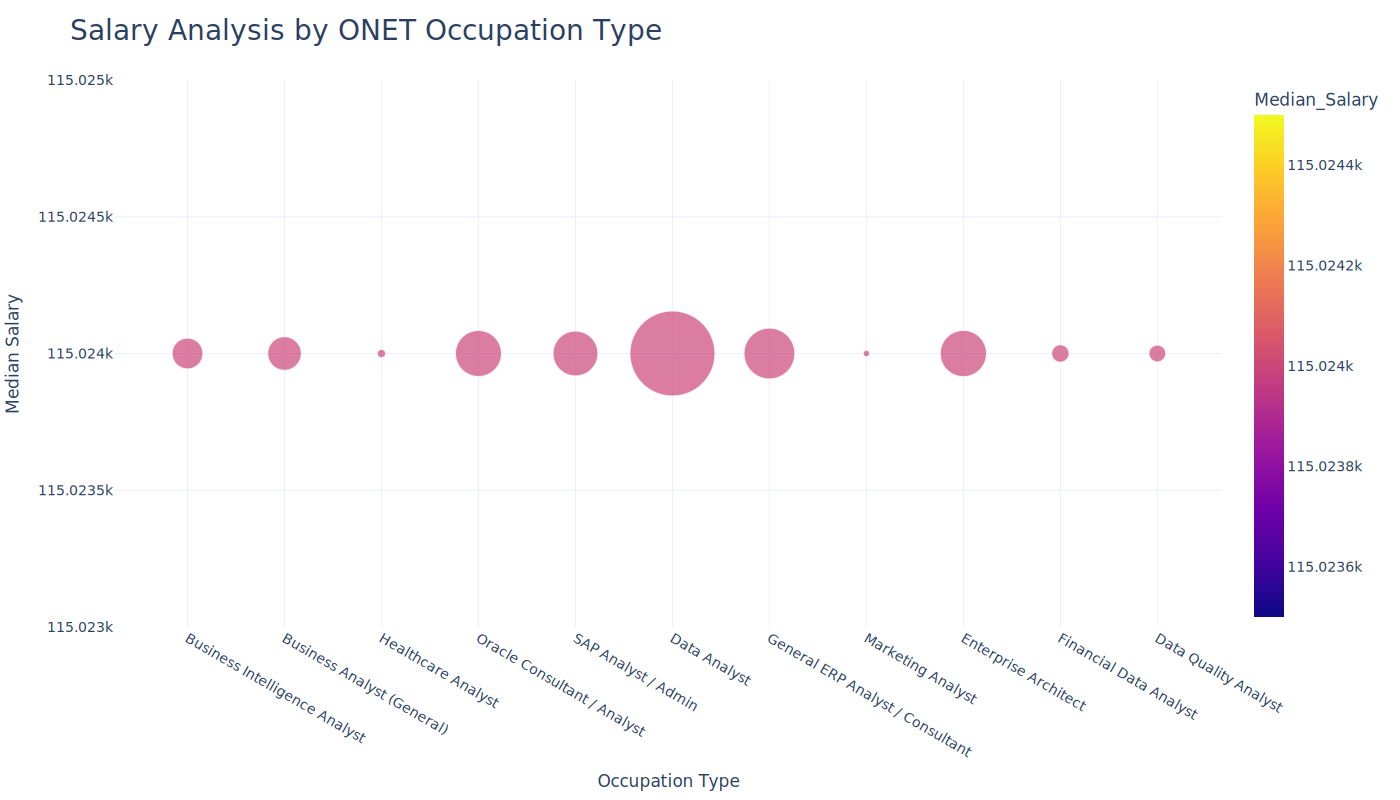

In [ ]:
from pyspark.sql.functions import col, expr, count
import plotly.express as px

valid_df = df.filter(
    col("SALARY").isNotNull() & (col("SALARY") > 0) &
    col("LOT_V6_SPECIALIZED_OCCUPATION_NAME").isNotNull()
)

valid_df = df.filter(
    col("SALARY").isNotNull() & (col("SALARY") > 0) &
    col("LOT_V6_SPECIALIZED_OCCUPATION_NAME").isNotNull() &
    (col("LOT_V6_SPECIALIZED_OCCUPATION_NAME") != "")
)

agg_df = df.filter(
    col("SALARY").isNotNull() & (col("SALARY") > 0) &
    col("LOT_V6_SPECIALIZED_OCCUPATION_NAME").isNotNull() &
    (col("LOT_V6_SPECIALIZED_OCCUPATION_NAME") != "")
).groupBy("LOT_V6_SPECIALIZED_OCCUPATION_NAME") \
 .agg(
    expr("percentile_approx(SALARY, 0.5, 100)").alias("Median_Salary"),
    count("*").alias("Job_Postings")
).withColumnRenamed("LOT_V6_SPECIALIZED_OCCUPATION_NAME", "Occupation_Name")

# Converting to pandas
bubble_pdf = agg_df.toPandas()

# Buble Chart
fig = px.scatter(
    bubble_pdf,
    x="Occupation_Name",
    y="Median_Salary",
    size="Job_Postings",
    color="Median_Salary",
    title="Salary Analysis by ONET Occupation Type",
    hover_name="Occupation_Name",
    size_max=60,
    template="plotly_white"
)

fig.update_layout(
    xaxis_title="Occupation Type",
    yaxis_title="Median Salary",
    width=1400,
    height=800,
    font=dict(family="Helvetica Neue", size=14),
    title_font=dict(size=28),
    margin=dict(l=40, r=40, t=80, b=120)
)

fig.show()

# 4 Salary by Education Level (Two Groups)

    Create two groups:
        Associate’s or lower (GED, Associate, No Education Listed)
        Bachelor’s (Bachelor’s degree)
        Master’s (Master’s degree)
        PhD (PhD, Doctorate, professional degree)
    Plot scatter plots for each group using, MAX_YEARS_EXPERIENCE (with jitter), Average_Salary, LOT_V6_SPECIALIZED_OCCUPATION_NAME
    After each graph, add a short explanation of key insights.

In [ ]:
from pyspark.sql.functions import col, when

lower_deg = ["Bachelor's", "Associate", "GED", "No Education Listed", "High school"]
higher_deg = ["Master's degree", "Ph.D. or professional degree"]

# Create education group column
df = df.withColumn(
    "EDU_GROUP",
    when(col("EDUCATION_LEVELS_NAME").rlike("|".join([f"(?i){deg}" for deg in lower_deg])), "Bachelor's or lower")
    .when(col("EDUCATION_LEVELS_NAME").rlike("|".join([f"(?i){deg}" for deg in higher_deg])), "Master's or PhD")
    .otherwise("Other")
)

# Cast columns properly
df = df.withColumn("MAX_YEARS_EXPERIENCE", col("MAX_YEARS_EXPERIENCE").cast("float"))
df = df.withColumn("Salary", col("Salary").cast("float"))

# Filter valid rows
df = df.filter(
    col("MAX_YEARS_EXPERIENCE").isNotNull() &
    col("Salary").isNotNull() &
    (col("MAX_YEARS_EXPERIENCE") > 0) &
    (col("Salary") > 0)
)

# Filter by education group
df_filtered = df.filter(col("EDU_GROUP").isin(["Bachelor's or lower", "Master's or PhD"]))
# Convert to pandas
df_pd = df_filtered.toPandas()

In [ ]:
import numpy as np

# Add jitter to experience values
df_pd["EXPERIENCE_JITTER"] = df_pd["MAX_YEARS_EXPERIENCE"] + np.random.uniform(-0.3, 0.3, size=len(df_pd))

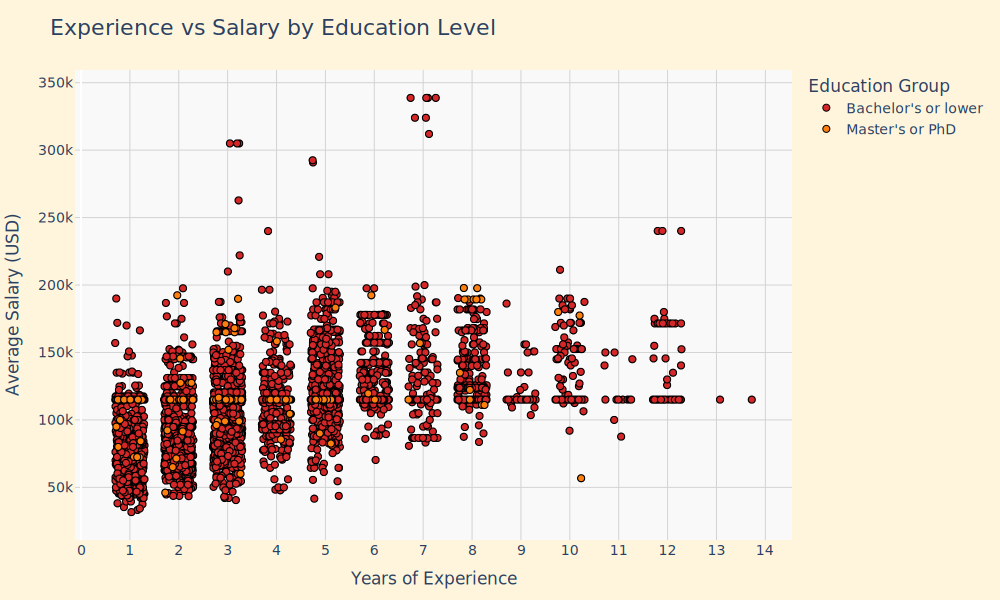

In [ ]:
fig1 = px.scatter(
    df_pd,
    x="EXPERIENCE_JITTER",
    y="Salary",
    color="EDU_GROUP",
    hover_data=["LOT_V6_SPECIALIZED_OCCUPATION_NAME"],
    title="Experience vs Salary by Education Level",
    opacity=1,
    color_discrete_sequence=["#d62728", "#ff7f0e"],
    width=1000,
    height=600
)

fig1.update_traces(marker=dict(size=7, line=dict(width=1, color="black")))

fig1.update_layout(
    plot_bgcolor="#f9f9f9",
    paper_bgcolor="#fff5dc",
    font=dict(family="Segoe UI", size=14),
    title_font=dict(size=22),
    xaxis_title="Years of Experience",
    yaxis_title="Average Salary (USD)",
    legend_title="Education Group",
    hoverlabel=dict(bgcolor="white", font_size=13, font_family="Arial"),
    margin=dict(t=70, b=60, l=60, r=60),
    xaxis=dict(gridcolor="lightgray", tickmode="linear", dtick=1),
    yaxis=dict(gridcolor="lightgray")
)
# Needed to use iframe due to it being unable to render in preview with just show and not specifiying renderer
fig1.show()
fig1.write_html("output/q_1a_experience_vs_salary_by_education_level.html")

# 4 Salary by Education Level (Four Groups)

    Create two groups:
        Associate’s or lower (GED, Associate, No Education Listed)
        Bachelor’s (Bachelor’s degree)
        Master’s (Master’s degree)
        PhD (PhD, Doctorate, professional degree)
    Plot scatter plots for each group using, MAX_YEARS_EXPERIENCE (with jitter), Average_Salary, LOT_V6_SPECIALIZED_OCCUPATION_NAME
    After each graph, add a short explanation of key insights.

In [ ]:
from pyspark.sql.functions import col, when

lowest_deg = ["Associate", "GED", "No Education Listed", "High school"]
bach_deg = ["Bachelor's"]
mast_deg = ["Master's degree"]
phd_deg = ["Ph.D. or professional degree"]

# Create education group column
df = df.withColumn(
    "EDU_GROUP",
    when(col("EDUCATION_LEVELS_NAME").rlike("|".join([f"(?i){deg}" for deg in lowest_deg])), "Associate's or lower")
    .when(col("EDUCATION_LEVELS_NAME").rlike("|".join([f"(?i){deg}" for deg in bach_deg])), "Bachelor's")
    .when(col("EDUCATION_LEVELS_NAME").rlike("|".join([f"(?i){deg}" for deg in mast_deg])), "Master's")
    .when(col("EDUCATION_LEVELS_NAME").rlike("|".join([f"(?i){deg}" for deg in phd_deg])), "PhD")
    .otherwise("Other")
)

# Cast columns properly
df = df.withColumn("MAX_YEARS_EXPERIENCE", col("MAX_YEARS_EXPERIENCE").cast("float"))
df = df.withColumn("Salary", col("Salary").cast("float"))

# Filter valid rows
df = df.filter(
    col("MAX_YEARS_EXPERIENCE").isNotNull() &
    col("Salary").isNotNull() &
    (col("MAX_YEARS_EXPERIENCE") > 0) &
    (col("Salary") > 0)
)

# Filter by education group
df_filtered2 = df.filter(col("EDU_GROUP").isin(["Associate's or lower", "Bachelor's", "Master's", "PhD"]))

# Convert to pandas
df_pd2 = df_filtered2.toPandas()

#see appendix 2 -- asked ai to help me fix the data being in a straight line and it suggested the jitter.

In [ ]:
import numpy as np

# Add jitter to experience values
df_pd2["EXPERIENCE_JITTER"] = df_pd2["MAX_YEARS_EXPERIENCE"] + np.random.uniform(-0.3, 0.3, size=len(df_pd2))

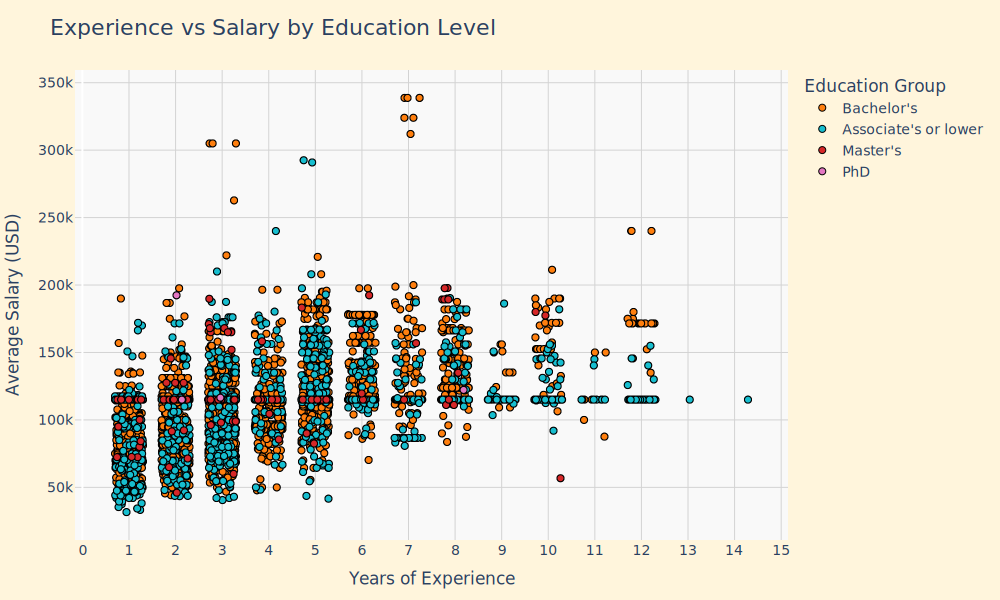

In [ ]:
fig2 = px.scatter(
    df_pd2,
    x="EXPERIENCE_JITTER",  # use jittered x-axis
    y="Salary",
    color="EDU_GROUP",
    hover_data=["LOT_V6_SPECIALIZED_OCCUPATION_NAME"],
    title="Experience vs Salary by Education Level",
    opacity=1,
    color_discrete_sequence=["#ff7f0e", "#17becf", "#d62728", "#e377c2", "#1f77b4"],
    width=1000,
    height=600
)

fig2.update_traces(marker=dict(size=7, line=dict(width=1, color="black")))

fig2.update_layout(
    plot_bgcolor="#f9f9f9",
    paper_bgcolor="#fff5dc",
    font=dict(family="Segoe UI", size=14),
    title_font=dict(size=22),
    xaxis_title="Years of Experience",
    yaxis_title="Average Salary (USD)",
    legend_title="Education Group",
    hoverlabel=dict(bgcolor="white", font_size=13, font_family="Arial"),
    margin=dict(t=70, b=60, l=60, r=60),
    xaxis=dict(gridcolor="lightgray", tickmode="linear", dtick=1),
    yaxis=dict(gridcolor="lightgray")
)
# Needed to use iframe due to it being unable to render in preview with just show and not specifiying renderer
fig2.show()
fig2.write_html("output/q_1a_experience_vs_salary_by_education_level_4.html")

In [ ]:
# Need to work on code below, for remote work type, and add graphs to break down the data

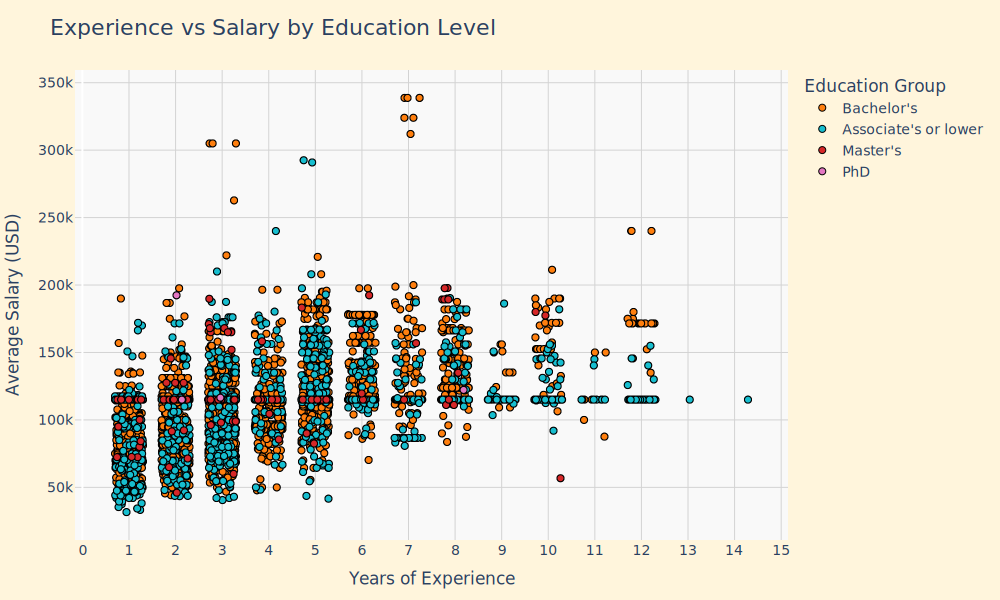

In [ ]:
from pyspark.sql.functions import col, when


Remote = ["Remote"]
Hybrid = ["Hybrid"]
Onsite = ["Onsite", "None", "Null"]

df = df.withColumn(
    "REMOTE_TYPE_NAME",
    when(col("REMOTE_TYPE_NAME").rlike("|".join([f"(?i){deg}" for deg in Remote])), "Remote")
    .when(col("REMOTE_TYPE_NAME").rlike("|".join([f"(?i){deg}" for deg in Hybrid])), "Hybrid")
    .when(col("REMOTE_TYPE_NAME").rlike("|".join([f"(?i){deg}" for deg in Onsite])), "Onsite")
    .otherwise("Other")
)

# Cast columns properly
df = df.withColumn("MAX_YEARS_EXPERIENCE", col("MAX_YEARS_EXPERIENCE").cast("float"))
df = df.withColumn("Salary", col("Salary").cast("float"))

# Filter valid rows
df = df.filter(
    col("MAX_YEARS_EXPERIENCE").isNotNull() &
    col("Salary").isNotNull() &
    (col("MAX_YEARS_EXPERIENCE") > 0) &
    (col("Salary") > 0)
)

# Filter by education group
df_filtered3 = df.filter(col("EDU_GROUP").isin(["Associate's or lower", "Bachelor's", "Master's", "PhD"]))

# Convert to pandas
df_pd3 = df_filtered3.toPandas()

import numpy as np

# Add jitter to experience values
df_pd3["EXPERIENCE_JITTER"] = df_pd3["MAX_YEARS_EXPERIENCE"] + np.random.uniform(-0.3, 0.3, size=len(df_pd3))

fig3 = px.scatter(
    df_pd2,
    x="EXPERIENCE_JITTER",  # use jittered x-axis
    y="Salary",
    color="EDU_GROUP",
    hover_data=["LOT_V6_SPECIALIZED_OCCUPATION_NAME"],
    title="Experience vs Salary by Education Level",
    opacity=1,
    color_discrete_sequence=["#ff7f0e", "#17becf", "#d62728", "#e377c2", "#1f77b4"],
    width=1000,
    height=600
)

fig3.update_traces(marker=dict(size=7, line=dict(width=1, color="black")))

fig3.update_layout(
    plot_bgcolor="#f9f9f9",
    paper_bgcolor="#fff5dc",
    font=dict(family="Segoe UI", size=14),
    title_font=dict(size=22),
    xaxis_title="Years of Experience",
    yaxis_title="Average Salary (USD)",
    legend_title="Education Group",
    hoverlabel=dict(bgcolor="white", font_size=13, font_family="Arial"),
    margin=dict(t=70, b=60, l=60, r=60),
    xaxis=dict(gridcolor="lightgray", tickmode="linear", dtick=1),
    yaxis=dict(gridcolor="lightgray")
)
# Needed to use iframe due to it being unable to render in preview with just show and not specifiying renderer
fig3.show()
fig3.write_html("output/q_1a_experience_vs_salary_by_education_level_5.html")